In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [6]:
torch.Tensor([0.0])

tensor([0.])

In [7]:
import graphviz

In [8]:
from graphviz import Digraph

def trace(root):
    # Builds a set of nodes and edges in the computation graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    print(root, root.op)
    # Trace the graph and render it using graphviz
    nodes, edges = trace(root)
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # Left-to-right graph

    for n in nodes:
        # For each node, create a corresponding graphviz node
        dot.node(str(id(n)), label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')

        if n.op:  # If there's an operation, render it
            dot.node(str(id(n)) + 'op', label=n.op)
            dot.edge(str(id(n)) + 'op', str(id(n)))

    for n1, n2 in edges:
        # Draw edges between nodes
        dot.edge(str(id(n1)), str(id(n2)) + 'op')

    return dot

In [9]:
def f(a,b,c):
  return a*b+c

# df/da = b
# df/db = a
# df/dc = 1

a = 2
b = -3
c = 10

h=0.0001
f1 = f(a,b,c)
f_a= f(a+h, b,c)
f_b = f(a,b+h,c)
f_c = f(a,b,c+h)

df_da = (f_a-f1) / h
df_db = (f_b-f1) / h
df_dc = (f_c - f1) / h

print(df_da) # -3
print(df_db) # 2
print(df_dc) # 1

-3.000000000010772
2.0000000000042206
0.9999999999976694


In [10]:
# Initial version of Value
import math
class Value:
  def __init__(self, data, children=(), op='', label=''):
    self.data = data
    self.prev = set(children)
    self.op = op
    self.label = label

    # gradient of destination w.r.t this Value
    self.grad = 0.0

  def __repr__(self):
    return f'Value {self.label}: {self.data}'

  def __add__(self, other):
    return Value(self.data + other.data, children=(self, other), op='+')

  def __sub__(self, other):
    return Value(self.data - other.data, children=(self, other), op='-')

  def __mul__(self, other):
    return Value(self.data * other.data, children=(self, other), op='*')

  def tanh(self):
    data = self.data
    val = (math.exp(2*data) - 1) / (math.exp(2*data) + 1)
    return Value(val, children = (self, ), op='tanh')

  def backward(self):
    self.grad = 1.0 # base case

    # set gradient fr prev until nothing left
    def set_grad(node, parent_grad):
      if not node.prev:
        return

      print("here")
      prev = list(node.prev)
      op = node.op
      left, right = prev[0], prev[1]

      if node.op == '*':
        left.grad += parent_grad * right.data
        right.grad += parent_grad * left.data
      elif node.op == '+':
        left.grad += parent_grad
        right.grad += parent_grad
      elif node.op == '-':
        left.grad += parent_grad
        right.grad += -parent_grad

      set_grad(left, left.grad)
      set_grad(right, right.grad)

    set_grad(self, 1.0)

In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')

e = a*b
e.label ='e'

c = Value(10, label='c')

d = e + c
d.label = 'd'

f = Value(-2.0, label='f')
L = d*f
L.label = 'L'


x = Value(3)
y = Value(4)
z = x-y

t = Value(2)
t2 = t.tanh()
print(t2)

Value : 0.9640275800758169


In [12]:
# gradient
# L = final value to backprop
# dL/dCurrent = (dParent / dCurrent) * (dL / dParent)
  # (how much does Parent increase if Current+1) * (how much does L increase if Parent+1)
  # => how much does L increase if Current+1 i.e dL/dCurrent

L.backward()


here
here
here


Value L: -8.0 *


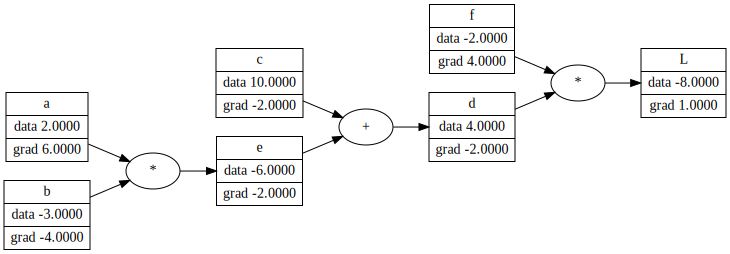

In [13]:

# Usage example:
dot = draw_dot(L)
dot


In [15]:
def hi():
  a = Value(2.0, label='a')
  b = Value(3.0, label='b')
  c = Value(4.0, label='c')

  d = (a*b)*c

  return draw_dot(d)

print(L)
print(L.prev)


Value L: -8.0
{Value f: -2.0, Value d: 4.0}


here
Value : -1 -


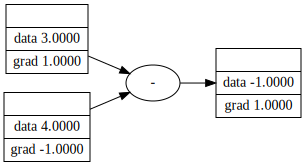

In [16]:
z.backward()
draw_dot(z)

In [17]:
x = Value(2.0, label='x')
y = Value(3.0, label='y')
z = x*y + x
z.label = 'z'

z.backward()
# draw_dot(z)

here
here


## MLP
inputs: x0,x1,x2...xn
weights: w0,w1,w2...wn

linear combination: w0x0 + w1x1 + ... + wn*xn
z = linear_comb + b
- bias = b, neuron's affinity for activation

neuron: activation(linear_comb + b)

e.g activation = tanh: domain is (-1,1) for all x

For backprop, the functions don't have to be atomic.
tanh has exponents but we could just define the rule for tanh gradient calculation instead of implementing exponents too.

# Actual Value class
- We can define the backward function locally for each operation
- Start at the last node with grad=1, then call backward recursively
- Base case: backward function does nothing for leaf nodes

# gradient
L = final value to backprop

dL/dCurrent = (dParent / dCurrent) * (dL / dParent)
- dParent/dCurrent is local derivative

- (how much does Parent increase if Current+1) * (how much does L increase if Parent+1)
- i.e how much does L increase if Current+1 i.e dL/dCurrent

Need to accumulate gradients (+=) to account for when variable used more than once. Otherwise we would overwrite.

In [18]:
import math
class Value:
  def __init__(self, data, children=(), op='', label=''):
    self.data = data
    self.prev = set(children)
    # self.prev = list(children)
    self.op = op
    self.label = label

    # gradient of destination w.r.t this Value
    self.grad = 0.0

    # function to call to backprop
    # default: leaf nodes do nothing
    self._backprop = lambda : None

  def __repr__(self):
    return f'Value {self.label}: {self.data}'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(float(other))
    result = Value(self.data + other.data, children=(self, other), op='+')

    def backprop():
      # get the parent gradient at the time of backpropagation
      parent_grad = result.grad
      self.grad += 1.0 * parent_grad
      other.grad += 1.0 * parent_grad

    result._backprop = backprop
    return result

  def __sub__(self, other):
    other = other if isinstance(other, Value) else Value(float(other))
    result = Value(self.data - other.data, children=(self, other), op='-')

    def backprop():
      # get the parent gradient at the time of backpropagation
      parent_grad = result.grad
      self.grad += 1.0 * parent_grad
      other.grad += -1.0 * parent_grad

    result._backprop = backprop

    return result

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(float(other))
    result = Value(self.data * other.data, children=(self, other), op='*')

    def backprop():
      parent_grad = result.grad
      self.grad += other.data * parent_grad
      other.grad += self.data * parent_grad

    result._backprop = backprop
    return result

  def __rmul__(self, other):
    return self.__mul__(other)

  # c = a/b
    # dc/da = 1/b
    # dc/db = -a/b^2
      # c = ab^-1, derivative of b^-1 = -b^(-2)
      # so overall is -a/b^2
  def __truediv__(self, other):
    other = other if isinstance(other, Value) else Value(float(other))
    result = Value(self.data / other.data, children = (self, other), op='/')

    def backprop():
      parent_grad = result.grad
      self.grad += (1 / other.data) * parent_grad
      other.grad += (-self.data / (other.data**2)) * parent_grad

    result._backprop = backprop
    return result

  def tanh(self):
    data = self.data
    # tanh(x)
    val = (math.exp(2*data) - 1) / (math.exp(2*data) + 1)
    result = Value(val, children = (self, ), op='tanh')

    def backprop():
      parent_grad = result.grad
      self.grad += (1 - val**2) * parent_grad

    result._backprop = backprop
    return result

  def backward(self):
    # to ensure all the node's parents are done with backprop before calling it,
    # so we get the correct parent_grad
    def topo_sort(root):
      vis = set()
      res = []

      def inner_topo(node):
        if node in vis:
          return

        for child in node.prev:
          inner_topo(child)

        res.append(node)

      inner_topo(root)
      return res

    res = topo_sort(self)

    self.grad = 1.0
    for node in reversed(res):
      node._backprop()

  def zero_grad(self):
    self.grad = 0.0

    for child in self.prev:
      child.zero_grad()

  def step(self, lr):
    self.data = self.data - lr * self.grad

Value L: -8.0 *


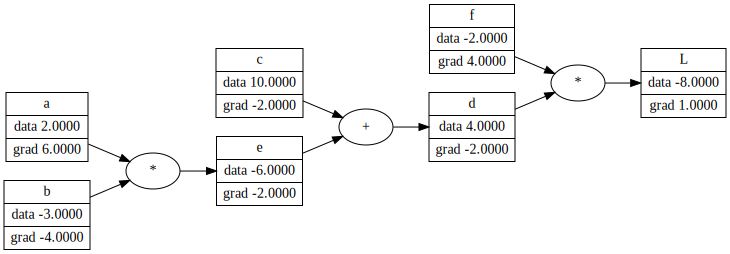

In [19]:

a = Value(2.0, label='a')
b = Value(-3.0, label='b')

e = a*b
e.label ='e'

c = Value(10, label='c')

d = e + c
d.label = 'd'

f = Value(-2.0, label='f')
L = d*f
L.label = 'L'

# Manually: set L.grad to 1 so we have base case, then call recursively
# L.grad = 1.0
# L._backprop()
# d._backprop()
# e._backprop()


L.backward()
draw_dot(L)

Value z: 8.0 +


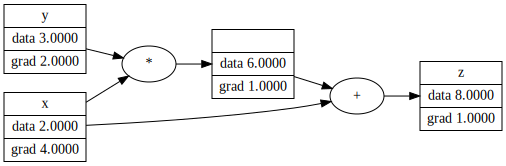

In [20]:
x = Value(2.0, label='x')
y = Value(3.0, label='y')
z = x*y + x
z.label = 'z'

z.backward()
# x.step(0.1)
# y.step(0.1)
draw_dot(z)

Value : -1.0 -


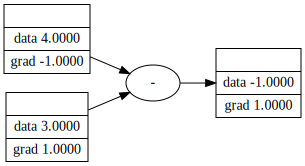

In [21]:
a = Value(3.0)
b = Value(4.0)
c = a - b

c.backward()
draw_dot(c)

## Linear regression from scratch

Pred: [Value : 0.0, Value : 0.0, Value : 0.0, Value : 0.0, Value : 0.0, Value : 0.0, Value : 0.0, Value : 0.0, Value : 0.0, Value : 0.0]
y: [Value y: 1, Value y: 3, Value y: 5, Value y: 7, Value y: 9, Value y: 11, Value y: 13, Value y: 15, Value y: 17, Value y: 19]
Loss: Value : 66.5
Pred: [Value : 0.3, Value : 2.145, Value : 3.99, Value : 5.835, Value : 7.680000000000001, Value : 9.525000000000002, Value : 11.370000000000001, Value : 13.215000000000002, Value : 15.060000000000002, Value : 16.905]
y: [Value y: 1, Value y: 3, Value y: 5, Value y: 7, Value y: 9, Value y: 11, Value y: 13, Value y: 15, Value y: 17, Value y: 19]
Loss: Value : 1.0756062499999985
Pred: [Value : 0.341925, Value : 2.41395, Value : 4.485975, Value : 6.558, Value : 8.630025, Value : 10.70205, Value : 12.774075, Value : 14.8461, Value : 16.918125, Value : 18.99015]
y: [Value y: 1, Value y: 3, Value y: 5, Value y: 7, Value y: 9, Value y: 11, Value y: 13, Value y: 15, Value y: 17, Value y: 19]
Loss: Value : 0.077164

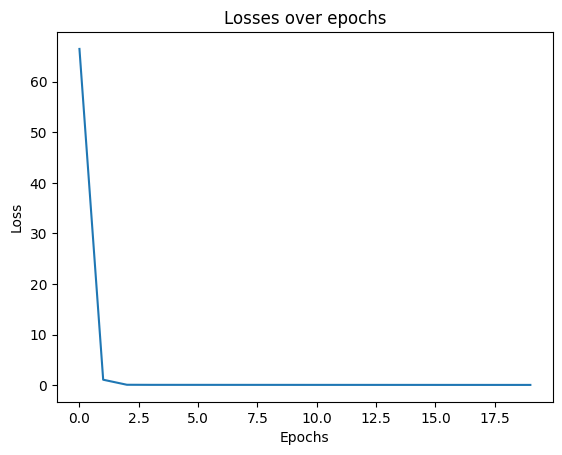

In [22]:
x = [Value(i, label=f'x{i}') for i in range(10)]
f = lambda x: 2*x+1

y = [Value(f(elem.data), label='y') for elem in x]

w1 = Value(0.0, label='w1')
b = Value(0.0, label='b')

def predict(x, w1, b):
  res = []
  for elem in x:
    prediction = w1 * elem + b
    res.append(prediction)

  return res

def get_loss(prediction, y):
  print("Pred:", prediction)
  print('y:', y)
  m = len(prediction)
  norm = Value(2*m)

  total = Value(0.0)
  for pred, actual in zip(prediction, y):
    res = pred - actual
    res = res * res
    total = total + res

  # 1/2m * total loss
  total = total / norm
  return total

EPOCHS = 20
# LR = Value(0.03)
LR=0.03
losses = []

for i in range(EPOCHS):
  prediction = predict(x,w1,b)
  loss = get_loss(prediction, y)
  print("Loss:", loss)
  losses.append(loss.data)

  loss.backward()

  # w1 = w1 - LR * Value(w1.grad)
  # b = b - LR * Value(b.grad)
  w1.step(LR)
  b.step(LR)

  loss.zero_grad()

# draw_dot(loss)

print(losses)
print("w1:", w1)
print("b", b)

plt.plot([i for i in range(len(losses))], losses)
plt.title("Losses over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Value : 1.5 /


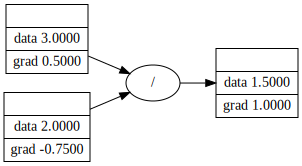

In [23]:
a = Value(3.0)
b = Value(2.0)
c = a / b
c.backward()

draw_dot(c)

## Same but with PyTorch

In [24]:
m = 10
# unsqueeze so it becomes a proper matrix and not just (10,)
x = torch.Tensor([i for i in range(m)]).double().unsqueeze(0) # 1 x 10

# w=2,b=1
f = lambda x: 2*x+1

y = torch.Tensor([f(i) for i in range(m)]).double()

# requires_grad so that it will track gradients. by default it won't
# to save on memory, efficiency etc
weights = torch.Tensor([0.0]).double()
weights.requires_grad = True

bias = torch.Tensor([0.0]).double()
bias.requires_grad = True

LR = 0.03
EPOCHS=20

for i in range(EPOCHS):
  # (10,1) (1,1)
  pred = (weights @ x) + bias
  loss = (pred - y)**2
  loss = loss / (2*m)
  loss = sum(loss) # squared error

  print("Loss", loss)

  loss.backward()

  # disable gradient calculation temporarily. since we are updating the weights
  # and bias. we don't want this update to contribute to gradient calculation
  with torch.no_grad():
    weights -= LR * weights.grad
    bias -= LR * bias.grad

  # zero out gradients on parameters for next iteration
  # grad is actually a Tensor and zero_() zeroes out the Tensor
  weights.grad.zero_()
  bias.grad.zero_()

# w=2.0893, b=0.4398, same as before
print("Weights:", weights)
print("Bias:", bias)

Loss tensor(66.5000, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(1.0756, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0772, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0609, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0597, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0587, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0577, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0567, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0557, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0548, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0539, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0530, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0521, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0512, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0503, dtype=torch.float64, grad_fn=<AddBackward0>)
Loss tensor(0.0495, dtyp

## Neurons and MLP with the Value class
- Each Neuron has n_in for number of inputs
  - i.e no.of features in one example
- Layer has n_out neurons
  - Input is fed through all of them so we get n_out outputs

In [25]:
import random

# n_in: number of inputs i.e x1,x2...xn
# w = weights w1..wn for each xi
# b = overall bias of the neuron
# result = activation(w.x + b) where . is dot product
  # activation = tanh in this case
class Neuron:
  def __init__(self, n_in):
    self.w = [Value(random.uniform(-1,1)) for i in range(n_in)]
    self.b = Value(random.uniform(-1,1))



  # w1x1 + w2x2 + wnxn + b -> tanh -> output
  def __call__(self, x):
    total = Value(0)
    for pair in zip(self.w, x):
      weight, x_val = pair
      total = total + weight * x_val

    total = total + self.b
    return total.tanh()

  # step weights and biases by learning rate. assumes grad is deposited already
  def step(self, lr):
    for w in self.w:
      w.step(lr)

    self.b.step(lr)

  # return flat array of w and b
  def parameters(self):
    return self.w + [self.b]


# fully connected to input layer - n_in for each Neuron
# n_out outputs
class Layer:
  def __init__(self, n_in, n_out):
    self.neurons = [Neuron(n_in) for i in range(n_out)]
    self.n_in = n_in
    self.n_out = n_out

  def __repr__(self):
    return f'Layer({self.n_in}, {self.n_out})'

  def __str__(self):
    return self.__repr__()

  # x is n_in length
  # outputs is n_out length
  def __call__(self, x):
    outputs = [neuron(x) for neuron in self.neurons]
    return outputs

  def step(self, lr):
    for neuron in self.neurons:
      neuron.step(lr)

  # collect parameters across neurons
  def parameters(self):
    res = []
    for neuron in self.neurons:
      params = neuron.parameters()
      res.extend(params)

    return res



# MLP: multi layer perceptron
# Take number of inputs n_in (in one example)
# Take nouts, a list of n_out sizes
  # defines the sizes of all the layers in the MLP
  # create layer objects for each n_out
# Call: call them sequentially

# e.g n_in=3, nouts = [4,4,1]
  # input is size 3
  # first layer: (3,4) - input -> 4 outputs
  # second layer: (4,4) - 4 outputs -> 4 outputs
  # third layer: (4,1) - 4 outputs -> 1 output
class MLP:
  def __init__(self, n_in, nouts):
    sizes = [n_in] + nouts
    self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)]

  # just go through the layers
  # returns a list of values, one for each layer. scalar if final layer has only
  # one output
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x[0] if len(x) == 1 else x


  def __repr__(self):
    return '\n'.join(list(map(lambda l: str(l), self.layers)))

  def __str__(self):
    return self.__repr__()

  def step(self, lr):
    for layer in self.layers:
      layer.step(lr)

  def parameters(self):
    res = []
    for layer in self.layers:
      params = layer.parameters()
      res.extend(params)

    return res


In [26]:
# x = [2.0, 3.0, 4.0]

# MLP desugared in terms of layers
# l1 = Layer(3,4)
# l2 = Layer(4,4)
# l3 = Layer(4,1)

# out = l1(x)
# out = l2(out)
# out = l3(out)

# 1 neuron: n_in + 1 params
# 1 layer: n_out neurons = n_out * (n_in + 1) params

# (3,4): 4*(3+1) = 16
# (4,4): 4*5 = 20
# (4,1): 1 * (4+1) = 5
# 41


mlp = MLP(3, [4,4,1])

## Binary classifier using MLP

In [27]:
# for consistent results
# random.seed(1097)

# Each example size 3, 4 examples total
# 4x3 matrix, m x n
# -1 or 1
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

mlp = MLP(3, [4,4,1])

# predictions
y_preds = [mlp(x) for x in xs]
print("Initial predictions:", y_preds)

def predict(xs, mlp):
  return [mlp(x) for x in xs]

# mean squared error: sum diff**2, divide by 2m
def get_loss(xs, ys, mlp):
  m = len(xs)
  y_preds = predict(xs, mlp)
  pairs = zip(y_preds, ys)

  loss = Value(0.0)

  for pred, y in pairs:
    diff = pred - y
    diff = diff * diff
    loss = loss + diff

  loss = loss / (2*m)
  return loss


EPOCHS=100
LR=0.06

for i in range(EPOCHS):
  # reset to 0
  for param in mlp.parameters():
    param.grad = 0.0

  loss = get_loss(xs, ys, mlp)

  print("Loss:", loss)

  # accumulate gradients
  loss.backward()

  # gradient step
  for param in mlp.parameters():
    param.data += -LR * param.grad


print("Result:", predict(xs, mlp))
print("Actual:", ys)

Initial predictions: [Value : 0.36244651110081066, Value : 0.5035271712909968, Value : 0.45605908236313886, Value : 0.5250291930786323]
Loss: Value : 0.6265967155971945
Loss: Value : 0.555885295308011
Loss: Value : 0.4699704452953327
Loss: Value : 0.4198029731035142
Loss: Value : 0.403944511855271
Loss: Value : 0.3418589234416316
Loss: Value : 0.2939744235896001
Loss: Value : 0.2595648716070625
Loss: Value : 0.226812669021387
Loss: Value : 0.22032585835239354
Loss: Value : 0.18109537500577624
Loss: Value : 0.15668550002616746
Loss: Value : 0.13659407294694773
Loss: Value : 0.12141187165231612
Loss: Value : 0.10934602514502502
Loss: Value : 0.10739207493418532
Loss: Value : 0.10306640725239975
Loss: Value : 0.0929378203772318
Loss: Value : 0.08908126330539498
Loss: Value : 0.07158031188061387
Loss: Value : 0.06641632535939385
Loss: Value : 0.06318697462214573
Loss: Value : 0.05691070858151559
Loss: Value : 0.053157619276571734
Loss: Value : 0.051015753864240704
Loss: Value : 0.044431556

## Notes
- Other loss functions: max-margin, cross entropy
- Other activation functions: sigmoid, ReLU
- Techniques: regularization, SGD
  - Stochastic gradient descent: instead of backprop on all the data,
  pick a subset of it each time and do forward, backward, weight update
  - Helps for large amounts of data
- LR decay: decrease LR each iteration